# Preprocessing and clustering

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.set_figure_params(dpi=80, facecolor="white")

The data used in this basic preprocessing and clustering tutorial was collected from bone marrow mononuclear cells of a healthy human donor and was part of Proceedings of the Neural Information Processing Systems Track on Datasets and Benchmarks 1 (NeurIPS Datasets and Benchmarks 2021) (Lücken et al. 2021, A sandbox for prediction and integration of DNA, RNA, and proteins in single cells). The sample used in this tutorial was measured using the 10X Multiome Gene Expression and Chromatin Accessability kit OR 10X 3' Single-Cell Gene Expression kit with Feature Barcoding in combination with the BioLegend TotalSeq B Universal Human Panel v1.0. (!!ToDo adjust after be picked the final sample)


We are reading in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data.

In [3]:
import scanpy as sc, anndata as ad

adatas = {}

for dset in ["s1d1", "s1d3"]:
    sample_adata = sc.read_10x_h5(f"data/basic_scrna_tutorial/{dset}/filtered_feature_bc_matrix.h5")
    sample_adata.var_names_make_unique()
    adatas[dset] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()

/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata

AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

The data contains 8,785 cells and 36,601 measured genes. This tutorial includes a basic preprocessing and clustering workflow. 

## Quality Control

The scanpy function `pp.calculate_qc_metrics` calculates common quality control (QC) metrics, which are largely based on `calculateQCMetrics` from scater [McCarthy17]. One can pass specific gene population to `pp.calculate_qc_metrics` in order to calculate proportions of counts for these populations. Mitochondrial, ribosomal and hemoglobin genes are defined by distinct prefixes as listed below. 

In [5]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [6]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

One can now inspect violin plots of some of the computed QC metrics:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

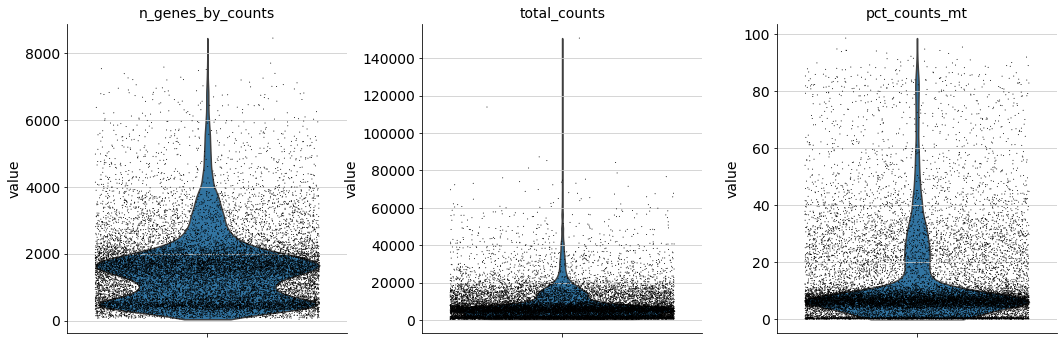

In [7]:
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)

Additionally, it is useful to consider QC metrics jointly by inspecting a scatter plot colored by `pct_counts_mt`. 

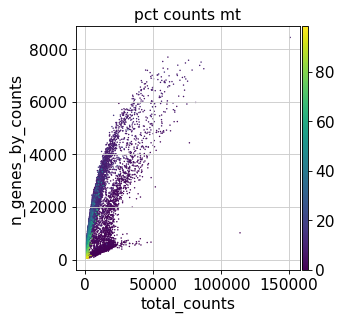

In [8]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Based on the QC metric plots, one could now remove cells that have too many mitochondrial genes expressed or too many total counts by setting manual or automatic thresholds. However, it proved to be beneficial to apply a very permissive filtering strategy in the beginning for your single-cell analysis and filter low quality cells during clustering or revisit the filtering again at a later point. We therefore now only filter cells with less than 100 genes expressed and genes that are detected in less than 3 cells. 

Additionally, it is important to note that for datasets with multiple batches, quality control should be performed for each sample individually as quality control thresholds can very substantially between batches. 

In [9]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

### Doublet detection

As a next step, we run a doublet detection algorithm. Identifying doublets is crucial as they can lead to misclassifications or distortions in downstream analysis steps. Scanpy contains the doublet detection method Scrublet [Wolock19]. Scrublet predicts cell doublets using a nearest-neighbor classifier of observed transcriptomes and simulated doublets. `external.pp.scrublet` adds `doublet_score` and `predicted_doublet` to `.obs`. One can now either filter directly on `predicted_doublet` or use the `doublet_score` later during clustering to filter clusters with high doublet scores. 

In [10]:
sc.external.pp.scrublet(adata, batch_key="sample")

/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Automatically set threshold at doublet score = 0.24
Detected doublet rate = 2.5%
Estimated detectable doublet fraction = 31.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 8.1%


/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 4.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.9%


Alternative methods for doublet detection within the scverse ecosystem are DoubletDetection and SOLO. 

## Normalization

The next preprocessing step is normalization. A common approach is count depth scaling with subsequent log plus one (log1p) transformation. Count depth scaling normalizes the data to a “size factor” such as the median count depth in the dataset, ten thousand (CP10k) or one million (CPM, counts per million). The size factor for count depth scaling can be controlled via `target_sum` in `pp.normalize_total`. We are applying CPM normalization with log1p transformation in this tutorial. 

In [11]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [12]:
# CPM count depth scaling
sc.pp.normalize_total(adata)
# Logarithmize the data:
sc.pp.log1p(adata)

## Feature selection

As a next step, we want to reduce the dimensionality of the dataset and only include the most informative genes. This step is commonly known as feature selection. The scanpy function `pp.highly_variable_genes` annotates highly variable genes by reproducing the R-implementations of Seurat [Satija15], Cell Ranger [Zheng17], and Seurat v3 [Stuart19] depending on the chosen `flavor`. 

In [13]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

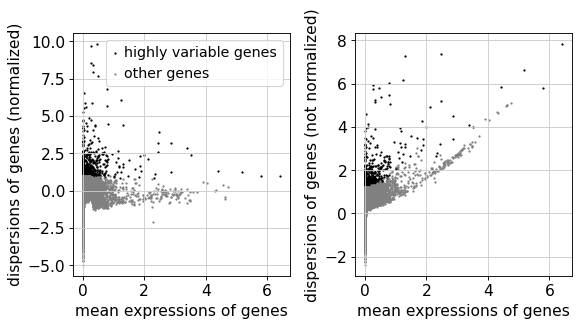

In [14]:
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [15]:
sc.tl.pca(adata)

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.leiden() or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.

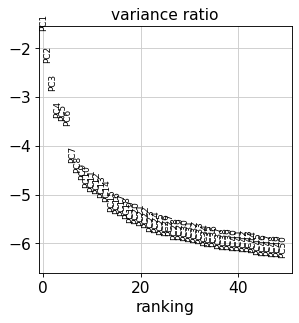

In [16]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

## Visualization

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix.

In [17]:
sc.pp.neighbors(adata)

We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. 

In [18]:
sc.tl.umap(adata)

We can now visualize the UMAP according to the `sample`. 

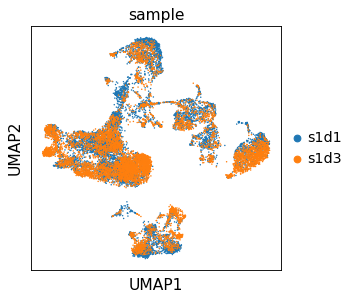

In [19]:
sc.pl.umap(adata, color="sample")

Even though the data considered in this tutorial includes two different samples, we only observe a minor batch effect and we can continue with clustering and annotation of our data. 

If you inspect batch effects in your UMAP it can be beneficial to integrate across samples and perform batch correction/integration. Please check out our advanced tutorial. 

## Clustering

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [ ]:
sc.tl.leiden(adata)

In [ ]:
sc.pl.umap(adata, color=["leiden"])

## Re-assess quality control and cell filtering 

As indicated before, we will now re-assess our filtering strategy by visualizing different QC metrics using UMAP. 

In [ ]:
adata.obs["predicted_doublet"] = adata.obs["predicted_doublet"].astype("category")
sc.pl.umap(adata, color=["leiden", "predicted_doublet", "doublet_score"], wspace=0.5)

The scrublet outputs `doublet_score` and `predicted_doublet` do not form a distinct cluster, we therefore can withdraw from filtering doublets from the dataset and aim to annotate these cells. 

In [ ]:
sc.pl.umap(adata, color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"], wspace=0.5)

## Annotation

In [ ]:
import decoupler as dc
import celltypist as ct

sc.set_figure_params(figsize=(7, 7))

We have now reached a point where we have obtained a set of cells with decent quality, and we can proceed to their annotation to known cell types. Typically, this is done using genes that are exclusively expressed by a given cell type, or in other words these genes are the marker genes of the cell types, and are thus used to distinguish the heterogeneous groups of cells in our data. Previous efforts have collected and curated various marker genes into available resources, such as [CellMarker](http://bio-bigdata.hrbmu.edu.cn/CellMarker/), [TF-Marker](http://bio.liclab.net/TF-Marker/), and [PanglaoDB](https://panglaodb.se/).

Commonly and classically, cell type annotation uses those marker genes subsequent to the grouping of the cells into clusters. So, let's generate a set of clustering solutions which we can then use to annotate our cell types. Here, we will use the Leiden clustering algorithm which will extract cell communities from our nearest neighbours graph.

In [ ]:
sc.tl.leiden(adata, key_added="leiden_res0_02", resolution=0.02)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res2", resolution=2)

Notably, the number of clusters that we define is largely arbitrary, and so is the `resolution` parameter that we use to control for it. As such, the number of clusters is ultemately bound to the stable and biologically-meaningful groups that we can ultimately distringuish, typically done by experts in the corresponding field or by using expert-curated prior knowledge in the form of markers.

In [ ]:
sc.pl.umap(
    adata,
    color=["leiden_res0_02", "leiden_res0_5", "leiden_res2"],
    legend_loc="on data",
)

Though UMAPs should not be over-interpreted, here we can already see that in the highest resolution our data is over-clustered, while the lowest resolution is likely grouping cells which belong to distinct cell identities.

### Marker gene set

Let's define a set of marker genes for the main cell types that we expect to see in this dataset. These were adapted from [sc-book annotation chapter](), for a more detailed overview and best practices in cell type annotation, we refer the user to it. **ToDo** add link to annotation chapter?

In [ ]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    "cDC2": [
        "CST3",
        "COTL1",
        "LYZ",
        "DMXL2",
        "CLEC10A",
        "FCER1A",
    ],  # Note: DMXL2 should be negative
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    "Proerythroblast": [
        "CDK6",
        "SYNGR1",
        "HBM",
        "GYPA",
    ],  # Note HBM and GYPA are negative markers
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],  # Note IGHD and IGHM are negative markers
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],  # Note PAX5 is a negative marker
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

In [ ]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res0_02")

Here, we can see that cluster `4` perhaps contains an admixture of monocytes and dendritic cells, while in cluster `1` we have different populations of B lymphocytes. Thus, we should perhaps consider a higher clustering resolution.

In [ ]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res0_5")

This seems like a resolution that suitable to distinguish most of the different cell types in our data. As such, let's try to annotate those by manually using the dotplot above, together with the UMAP of our clusters. Ideally, one would also look specifically into each cluster, and attempt to subcluster those if required.

In [ ]:
new_cluster_names = {
    "0": "CD4+ T cells",
    "1": "CD4+ T cells",
    "2": "Erythroblast",
    "3": "CD14+ Mono",
    "4": "CD8+ T cells",
    "5": "Naive CD20+ B Cells",
    "6": "Proerythroblast",
    "7": "CD4+ T cells",  # though questinable
    "8": "Naive CD20+ B Cells",
    "9": "Erythroblast",
    "10": "NK",
    "11": "Unknown",
    "12": "B cells",
    "13": "Plasma Cells",
    "14": "cDC2",
    "15": "CD14+ Mono",
    "16": "Proerythroblast",
    "17": "Proerythroblast",
}

In [ ]:
adata.obs["manual_anno"] = [new_cluster_names[x] for x in adata.obs["leiden_res0_5"]]
adata.obs["manual_anno"] = adata.obs["manual_anno"].astype("category")

We can now plot our rough annotations against the clustering results that we chose to use.

In [ ]:
sc.pl.umap(
    adata,
    color=["manual_anno", "leiden_res0_5"],
    legend_loc="on data",
)

These look okay as a start, though certain clusters can be further refined, including those which we assigned as 'Unknown'. Let's also look at a dendogram that represents the hierarchical clustering of predefined groups according to the cluster labels.

In [ ]:
sc.pl.dendrogram(adata, groupby="manual_anno")

Here, the dendogram confirms that the hierarchical relationships between our cell typese are largely what we expected. Also, it suggests that likely one of our unknown cell clusters is one from the B lymphocytes lineage. So let's rename it to something suitable, and we can return later to refining our annotation.

In [ ]:
adata.obs["manual_anno"] = adata.obs["manual_anno"].replace("Unknown", "B-cell lineage")

### Automatic label prediction

In addition to using marker collections to annotate our labels, there exist approaches to automatically annotate scRNA-seq datasets. One such tool is [CellTypist](https://github.com/Teichlab/celltypist), which uses gradient-descent optimised logistic regression classifiers to predict cell type annotations.

First, we need to retrive the CellTypist models that we wish to use, in this case we will use models with immune cell type and subtype populations generated using 20 tissues from 18 studies ([Domínguez Conde, et al. 2022](https://www.science.org/doi/full/10.1126/science.abl5197)). 

In [ ]:
ct.models.download_models(model=["Immune_All_Low.pkl"], force_update=True)

Then we predict the major cell type annotations. In this case we will enable `majority_voting`, which will assign a label to the clusters that we obtained previously.

In [ ]:
model = ct.models.Model.load(model="Immune_All_Low.pkl")
predictions = ct.annotate(adata, model="Immune_All_Low.pkl", majority_voting=True, over_clustering="leiden_res0_5")
# convert back to anndata||
adata = predictions.to_adata()

Let's examine the results of automatic clustering, together with our manual annotation:

In [ ]:
sc.pl.umap(adata, color=["majority_voting", "manual_anno"], ncols=1)

Note that our previously 'Unknown' cluster is now assigned as 'Pro-B cells'.

### Annotation with enrichment analysis

Automatic cell type labelling with methods that require pre-trained models will not always work as smoothly, as such classifiers need to be trained on and be representitive for a given tissue and the cell types within it. So, as a more generalizable approach to annotate the cells, we can also use the marker genes from any database, for example [PanglaoDB](https://panglaodb.se/). Here we will use it with simple multi-variate linear regression, implemented in [decoupler](https://github.com/saezlab/decoupler-py). Essentially, this will test if any collection of genes are enriched in any of the cells. Ultimately, this approach is similar to many other marker-based classifiers.

Let's get canonical cell markers using with [decoupler](https://github.com/saezlab/decoupler-py) which queries the OmniPath metadata-base to obtain the [PanglaoDB](https://panglaodb.se/) marker gene database with cannonical cell type markers.

In [ ]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource(name="PanglaoDB", organism="human")
# Keep canonical cell type markers alone
markers = markers[(markers["canonical_marker"] == "True")]

# Remove duplicated entries
markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]
markers.head()

In [ ]:
dc.run_mlm(mat=adata, net=markers, weight=None, source="cell_type", target="genesymbol", verbose=True, use_raw=False)

The obtained results are stored in the .obsm key, with `mlm_estimate` representing coefficient t-values:

In [ ]:
adata.obsm["mlm_estimate"].head()

To visualize the obtianed scores, we can re-use any of scanpy’s plotting functions. 
First though, we will extract them from the adata object.

In [ ]:
acts = dc.get_acts(adata=adata, obsm_key="mlm_estimate")
sc.pl.umap(
    acts,
    color=[
        "majority_voting",
        "B cells",
        "T cells",
        "Monocytes",
        "Erythroid-like and erythroid precursor cells",
        "NK cells",
    ],
    wspace=0.5,
    ncols=3,
)

These results further confirm the our automatic annotation with Celltypist as well as the manually defined clusters. In addition, here we can also transfer the max over-representation score estimates to assign a label to each cluster.

In [ ]:
mean_enr = dc.summarize_acts(acts, groupby="leiden_res0_5", min_std=1.0)
annotation_dict = dc.assign_groups(mean_enr)
adata.obs["dc_anno"] = [annotation_dict[clust] for clust in adata.obs["leiden_res0_5"]]

Let's compare all resulting annotations here

In [ ]:
sc.pl.umap(adata, color=["majority_voting", "manual_anno", "dc_anno"], ncols=1)

Great. We can see that the three different approaches to annotate the data are largely concordant. Though, these annotations are decent, cell type annotation is laborous and repetitive task, one which typically requires multiple rounds of sublucstering and re-annotation. Nevertheless, we now have a good basis with which we can further proceed with manually refining our annotations. 

### Differentially-expressed Genes as Markers

Furthermore, one can also calculate marker genes per cluster and then look up whether we can link those marker genes to any known biology, such as cell types and/or states. This is typically done using simple statistical tests, such as Wilcoxon and t-test, for each cluster vs the rest.

In [ ]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res0_5")
# Filter those
sc.tl.filter_rank_genes_groups(adata, min_fold_change=1.5)

We can then visualize the top 5 differentially-expressed genes on a dotplot.

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden_res0_5", standard_scale="var", n_genes=5)

We see that *LYZ*, *ACT8*, *S100A6*, *S100A4*, and *CST3* are all highly expressed in cluster `3`.
Let's visualize those at the UMAP space:

In [ ]:
cluster3_genes = ["LYZ", "ACTB", "S100A6", "S100A4", "CST3"]
sc.pl.umap(adata, color=[*cluster3_genes, "leiden_res0_5"], legend_loc="on data", frameon=False, ncols=3)

Similarly, we can also generate a Violin plot with the distrubtions of the same genes across the clusters.

In [ ]:
sc.pl.violin(adata, keys=cluster3_genes[0:3], groupby="leiden_res0_5", multi_panel=True)